In [77]:
import pandas as pd
import os
import dotenv
dotenv.load_dotenv()

True

In [78]:
neon_db_url = os.environ.get("NEON_DB_CONSTR")

In [79]:
# with pandas, select * from enhanced_price_table from NEONDB where symbol = symbol

# create query select left join where stock_data.stock_id equals select stock_id from stock where symbol = symbol
def get_stock_data(_symbol, _interval, _neon_db_url):
    q = (
         "select {table}.*, stock.symbol, stock.is_relative "
         "from {table} "
         "left join stock on {table}.stock_id = stock.id "
         "where stock.symbol = '{symbol}' "
         "and stock.interval = '{interval}' "
         "{extra}"
    ).format
    
    _stock_data = pd.read_sql(q(table='stock_data', symbol=_symbol, interval=_interval, extra="order by stock_data.bar_number asc"), con=_neon_db_url)
    _regime_data = pd.read_sql(q(table='regime', symbol=_symbol, interval=_interval, extra=""), con=_neon_db_url)
    _peak_data = pd.read_sql(q(table='peak', symbol=_symbol, interval=_interval, extra=""), con=_neon_db_url)
    return _stock_data, _regime_data, _peak_data

def get_data_by_market(_market_index, _interval, _neon_db_url, tables=None):
    if tables is None:
        tables = ['stock_data', 'regime', 'peak']
    q = (
         "select {table}.*, stock.symbol, stock.is_relative "
         "from {table} "
         "left join stock on {table}.stock_id = stock.id "
         "where stock.market_index = '{market}' "
         "and stock.interval = '{interval}' "
         "{extra}"
    ).format
    table_lookup = {
        'stock_data': lambda: pd.read_sql(q(table='stock_data', market=_market_index, interval=_interval, extra="order by stock_data.bar_number asc"), con=_neon_db_url),
        'regime': lambda: pd.read_sql(q(table='regime', market=_market_index, interval=_interval, extra=""), con=_neon_db_url),
        'peak': lambda: pd.read_sql(q(table='peak', market=_market_index, interval=_interval, extra=""), con=_neon_db_url)
    }
    result = [table_lookup[table]() for table in tables]
    return result

def aggregate_regime(_regime_table, by_regime=None):
    regime_types = _regime_table.type.unique()
    if by_regime is None:
        by_regime = regime_types
    # else throw error if by_regime not in regime_types
    elif not set(by_regime).issubset(set(regime_types)):
        raise ValueError(f"by_regime must be a subset of {regime_types}")

    # new df set index using start and end cols of spy_regime as range
    rg_long_table = pd.DataFrame(
        index=pd.RangeIndex(start=_regime_table.start.min(), stop=_regime_table.end.max(), step=1))
    # for each unique symbol in spy_regime, create a new column in spy_rg
    for _symbol in _regime_table.symbol.unique():
        rgs = _regime_table.loc[_regime_table.symbol == _symbol].copy()
        symbol_rg = rg_long_table.copy()
        for index, row in rgs.iterrows():
            symbol_rg.loc[row.start:row.end, row.type] = row.rg
        # aggregate rg_types by mean
        rg_long_table[_symbol] = symbol_rg[by_regime].mean(axis=1)
    return rg_long_table

In [80]:
# graph regime for all SPY sector etfs
(spy_regime,) = get_data_by_market('SPY', '1d', neon_db_url, tables=['regime'])
# drop ONEQ as it is not a sector etf

spy, _, __ = get_stock_data('SPY', '1d', neon_db_url)
spy.index = spy.bar_number
spy.index.name = 'index'


<AxesSubplot:title={'center':'Relative Regime Counts'}>

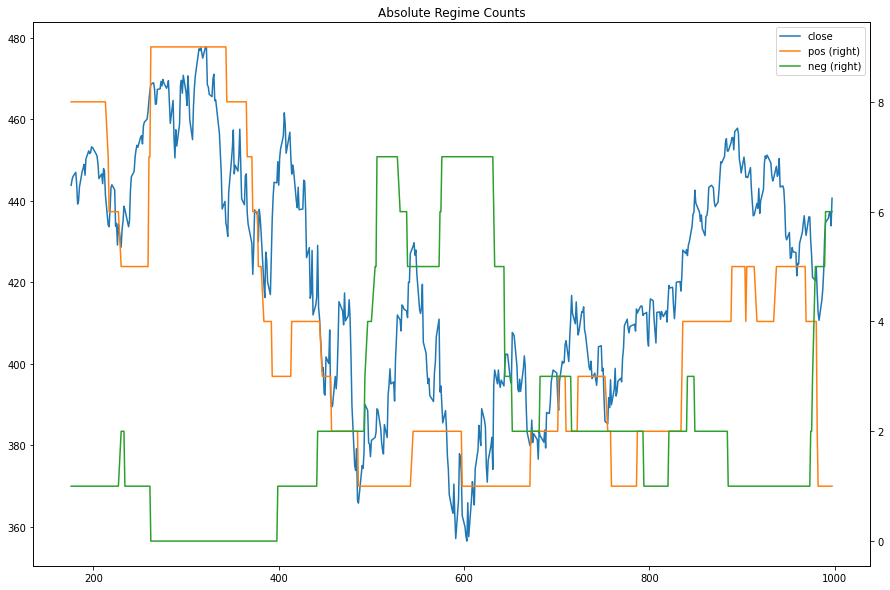

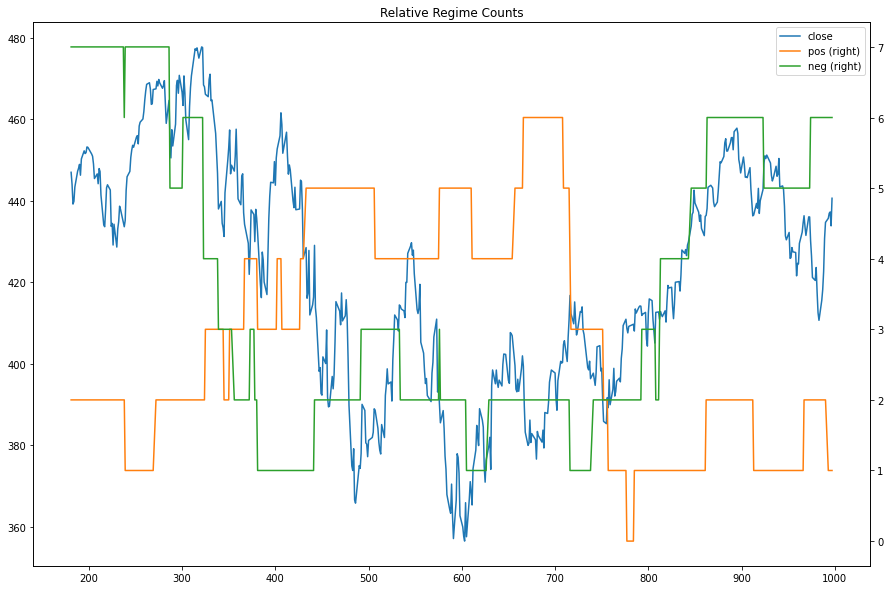

In [81]:
pos_counter = lambda x: x == 1
neg_counter = lambda x: x == -1
spy_regime = spy_regime.loc[spy_regime.symbol != 'ONEQ'].copy()

abs_agg_regimes = aggregate_regime(spy_regime.loc[spy_regime.is_relative == False].copy()).dropna()
abs_regime_counts = pd.DataFrame({
    'pos': abs_agg_regimes.apply(pos_counter).sum(axis=1),
    'neg': abs_agg_regimes.apply(neg_counter).sum(axis=1)
})
# merge counts on spy where count index = spy.bar_number
abs_spy = spy.loc[spy.is_relative == False].copy()
# set index to bar_number
abs_spy.set_index('bar_number', inplace=True)
# merge counts with spy on index
abs_regime_counts = abs_spy[['close']].merge(abs_regime_counts, left_index=True, right_index=True)
# plot
abs_regime_counts.plot(figsize=(15, 10), secondary_y=['neg', 'pos'], title='Absolute Regime Counts')
rel_agg_regimes = aggregate_regime(spy_regime.loc[spy_regime.is_relative == True].copy()).dropna()

rel_agg_regime_count = pd.DataFrame({
    'pos': rel_agg_regimes.apply(pos_counter).sum(axis=1),
    'neg': rel_agg_regimes.apply(neg_counter).sum(axis=1)
})
rel_regime_counts = abs_spy[['close']].merge(rel_agg_regime_count, left_index=True, right_index=True)
rel_regime_counts.plot(figsize=(15, 10), secondary_y=['neg', 'pos'], title='Relative Regime Counts')

In [85]:
# current scoreboard (current values) of aggregate regime in absolute, relative as one dataframe
current_regime = pd.DataFrame({
    'abs': abs_agg_regimes.iloc[-1],
    'rel': rel_agg_regimes.iloc[-1]
})

current_regime

,abs,rel
XLE,1.000000,0.5
XLF,-1.000000,-1.0
XLU,-1.000000,-1.0
XLI,-1.000000,-1.0
XLK,0.500000,1.0
XLV,-1.000000,-1.0
XLY,0.333333,0.0
XLP,-1.000000,-1.0
XLB,-1.000000,-1.0


SyntaxError: invalid syntax (3023384129.py, line 51)

In [10]:
import src.position_calculation as pc
stop = 451.64
cost = 448.66
fraction = 2/3
pc.TwoLegTradeEquation.Solve.price(stop, cost, fraction)
pc.PositionSize.Solve.quantity(stop, cost, 1000)

In [34]:
from ib_insync import *
util.startLoop()
ib1 = IB()


In [35]:
with IB() as ib:
    ib.connect('127.0.0.1', 7496, clientId=0)
    # contract = Future('ES', '20210917', 'GLOBEX')
    contract = Future('QG', exchange='NYMEX', localSymbol='QGZ3')
    # contract1 = Future('MES', exchange='CME', localSymbol='MESZ3')
    # bars = ib.reqHistoricalData(
    #     contract=contract1,
    #     endDateTime='',
    #     durationStr='365 D',
    #     barSizeSetting='1 day',
    #     whatToShow='TRADES',
    #     useRTH=True,
    #     formatDate=1)
    # df = util.df(bars)
    # df
    res = ib1.reqContractDetails(Contract(symbol='MES', secType='FUT'))
    ib1.qualifyContracts(res[0].contract)
res[0].contract

ConnectionError: Not connected